
# 1. Ajuste de hiperparámetros: Métodos alternativos a fuerza bruta. 

Validación cruzada de métodos especificos.

Algunos modelos pueden ajustar datos para un rango de parámetros casi tan eficientemente como para un parámetro. Esta característica tiene la ventaja de realizar una validación cruzada más eficiente para la selección de modelo para este parámetro. 

# Ejercicio: 

Para los siguientes modelos de regresión obtenga los mejores parámetros y el score de MSE utilizando el dataset de "boston house-prices":


In [10]:
#linear_model.LarsCV([fit_intercept, …]) 

In [11]:
#linear_model.LassoCV([eps, n_alphas, …]) 

In [12]:
#linear_model.LassoLarsCV([fit_intercept, …])

También para los siguientes métodos de clasificación, obtenga el mejor parámetro, los scores de precision-recall utilizando el dataset de "boston house-prices":

In [13]:
#linear_model.RidgeCV([alphas, …])

In [14]:
#linear_model.RidgeClassifierCV([alphas, …])

# 1.2. Criterios de información:

Como ya vimos, algunos modelos pueden ofrecer información del óptimo parámetro de regulación basado en un criterio cerrado, computando un camino de regularización. 



# Ejercicio: 
Obtenga las curvas de AIC y BIC para el siguiente modelo. Utilice el dataset de breast_cancer

In [16]:
# linear_model.LassoLarsIC([criterion, …])



# 1.3. Estimados Out of Bag:

Es posible utilizar un ensamble de métodos para realizar bagging. Para esto se generan nuevos conjuntos de entrenamiento utilizando muestreo con remplazo, parte de los conjuntos de entrenamiento permanecen sin ser utilizados. Para cada clasificador, una diferente parte del conjunto de entrenamiento se deja "fuera de la bolsa".

Esta porción que es dejada por fuera puede ser utilizada para estimar el error de generalización sin tener que depender de un conjunto de validación separado. Este estimado no requiere datos nuevos y puede ser utilizado para selección de modelo. 




### 1.3.1 RandomForestClassifier:

ensemble.RandomForestClassifier([…]) 	

Un RandomForest es un meta estimador que ajusta un número de clasificadores de árboles de decisión en diferentes submuestras del conjunto de datos y los utiliza los promedios para mejorar la precisión predictiva y el control del sobreajuste. El tamaño del subconjunto siempre es del tamaño de la muestra original, pero las muestras son dibujadas con remplazo si bootstrap=True.

### 1.3.2 RandomForestRegressor:

ensemble.RandomForestRegressor([…]) 	

El regresor de random forest es un meta estimador que ajusta un número de árboles de decisión de clasificación en varios subconjuntos del dataset y utiliza promedios para mejorar la precisión predictiva y el control del sobreajuste. El tamaño del subconjunto de la muestra es del tamaño de la entrada original pero las muestras son dibujadas con remplazo si "bootstrap=True."



### 1.3.3 GradientBoostingClassifier:

ensemble.GradientBoostingClassifier([loss, …]) 	
Este método construye un modelo aditivo; permite la optimización de funciones de pérdida arbitrarias. En cada etapa se ajustan "n_classes_" de regresión en el gradiente de la función de pérdida binomial o multinomial. La clasificación binaria es un casoespecial en el que sólo se induce un árbol de regresión. Las características son siempre permutadas en cada split. Por lo tanto, el mejor split puede variar, incluso en el mismo conjunto de entrenamiento y "max_features=n_features", si la mejora del criterio es idéntica para muchos splits enumerados durante la búsqueda del mejor split. Para obtener un comportamiento determinístico, se puede fijar el random_state.



Accuracy: 0.6820


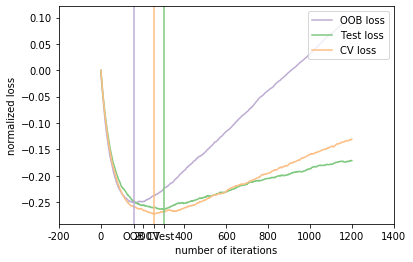

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from scipy.special import expit

# Generate data (adapted from G. Ridgeway's gbm example)
n_samples = 1000
random_state = np.random.RandomState(13)
x1 = random_state.uniform(size=n_samples)
x2 = random_state.uniform(size=n_samples)
x3 = random_state.randint(0, 4, size=n_samples)

p = expit(np.sin(3 * x1) - 4 * x2 + x3)
y = random_state.binomial(1, p, size=n_samples)

X = np.c_[x1, x2, x3]

X = X.astype(np.float32)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,
                                                    random_state=9)

# Fit classifier with out-of-bag estimates
params = {'n_estimators': 1200, 'max_depth': 3, 'subsample': 0.5,
          'learning_rate': 0.01, 'min_samples_leaf': 1, 'random_state': 3}
clf = ensemble.GradientBoostingClassifier(**params)

clf.fit(X_train, y_train)
acc = clf.score(X_test, y_test)
print("Accuracy: {:.4f}".format(acc))

n_estimators = params['n_estimators']
x = np.arange(n_estimators) + 1


def heldout_score(clf, X_test, y_test):
    """compute deviance scores on ``X_test`` and ``y_test``. """
    score = np.zeros((n_estimators,), dtype=np.float64)
    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        score[i] = clf.loss_(y_test, y_pred)
    return score


def cv_estimate(n_splits=None):
    cv = KFold(n_splits=n_splits)
    cv_clf = ensemble.GradientBoostingClassifier(**params)
    val_scores = np.zeros((n_estimators,), dtype=np.float64)
    for train, test in cv.split(X_train, y_train):
        cv_clf.fit(X_train[train], y_train[train])
        val_scores += heldout_score(cv_clf, X_train[test], y_train[test])
    val_scores /= n_splits
    return val_scores


# Estimate best n_estimator using cross-validation
cv_score = cv_estimate(3)

# Compute best n_estimator for test data
test_score = heldout_score(clf, X_test, y_test)

# negative cumulative sum of oob improvements
cumsum = -np.cumsum(clf.oob_improvement_)

# min loss according to OOB
oob_best_iter = x[np.argmin(cumsum)]

# min loss according to test (normalize such that first loss is 0)
test_score -= test_score[0]
test_best_iter = x[np.argmin(test_score)]

# min loss according to cv (normalize such that first loss is 0)
cv_score -= cv_score[0]
cv_best_iter = x[np.argmin(cv_score)]

# color brew for the three curves
oob_color = list(map(lambda x: x / 256.0, (190, 174, 212)))
test_color = list(map(lambda x: x / 256.0, (127, 201, 127)))
cv_color = list(map(lambda x: x / 256.0, (253, 192, 134)))

# plot curves and vertical lines for best iterations
plt.plot(x, cumsum, label='OOB loss', color=oob_color)
plt.plot(x, test_score, label='Test loss', color=test_color)
plt.plot(x, cv_score, label='CV loss', color=cv_color)
plt.axvline(x=oob_best_iter, color=oob_color)
plt.axvline(x=test_best_iter, color=test_color)
plt.axvline(x=cv_best_iter, color=cv_color)

# add three vertical lines to xticks
xticks = plt.xticks()
xticks_pos = np.array(xticks[0].tolist() +
                      [oob_best_iter, cv_best_iter, test_best_iter])
xticks_label = np.array(list(map(lambda t: int(t), xticks[0])) +
                        ['OOB', 'CV', 'Test'])
ind = np.argsort(xticks_pos)
xticks_pos = xticks_pos[ind]
xticks_label = xticks_label[ind]
plt.xticks(xticks_pos, xticks_label)

plt.legend(loc='upper right')
plt.ylabel('normalized loss')
plt.xlabel('number of iterations')

plt.show()


### 1.3.4 GradientBoostingRegressor


ensemble.GradientBoostingRegressor([loss, …]) 	

Crea un modelo aditivo por etapas; permite la optimización de funciones diferenciables arbitrarias. En cada etapa de regresión el arbol es ajustado al gradiente negativo de la función de costo. 


MSE: 6.5323


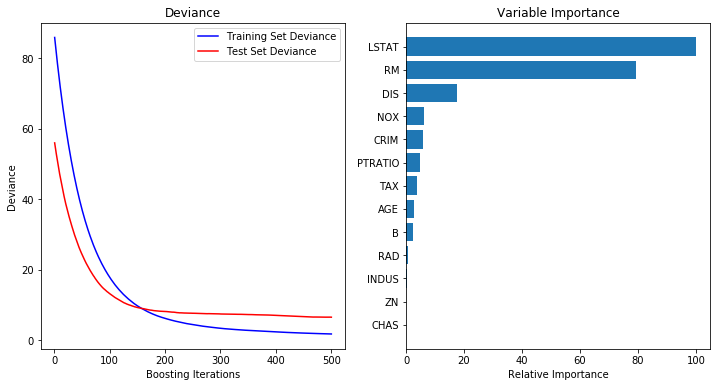

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error

# #############################################################################
# Load data
boston = datasets.load_boston()
X, y = shuffle(boston.data, boston.target, random_state=13)
X = X.astype(np.float32)
offset = int(X.shape[0] * 0.9)
X_train, y_train = X[:offset], y[:offset]
X_test, y_test = X[offset:], y[offset:]

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))
print("MSE: %.4f" % mse)

# #############################################################################
# Plot training deviance

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, boston.feature_names[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

# 2. Métricas de clasificación y regresión:
Para el dataset iris, descarte una clase y obtenga las siguientes métricas y comparelas. Puede utilizar un SVC y recuerde que para obtener "y_prob" debe pedirle al constructor del objeto que le retorne las probabilidades asociadas a cada clase. De igual manera para los ejercicios de regresión (aquí utilice house prices)

In [ ]:
#brier_score_loss(y_true, y_prob)
#matthews_corrcoef(y_true, y_pred)  
#log_loss(y_true, y_prob)    


In [19]:
#mean_squared_error
#r2_score
#mean_squared_log_error


# 3. Calibración de modelos de clasificación:

Cuando se realiza clasificación usualmente se desea no sólo predecir la etiqueta de la clase sino la probabilidad asociada. Esta probabilidad da algún tipo de confianza sobre la predicción. Sin embargo, no todos los clasificadores proveen probabilidades calibradas, algunos son "sobre confiados" \textit{overconfident} mientras que otros son "sub confiados" \textit{underconfident}. Entonces, una calibración separada de probabilidades es usualmente deseable como postprocesamiento. Hay diferentes métodos que se pueden utilizar para evaluar clasificación y evalúan la calidad de las probabilidades utilizando el score de Brier. 

A continuación se compara la probabilidad utilizando un clasificador "naive Bayes" sin calibrar con una calibración signoidal, y con calibración no paramétrica isotónica. Uno puede observar que sólo el modelo no paramétrico es capaz de proveer una calibración que retorne las probabilidades cerca al 0.5 esperado para la mayoría de muestras que pertenecen al cluster de la mitad con etiquetas heterogéneas. Esto resulta en un muy mejorado puntaje de Brier.

#### CalibratedClassifierCV

Con esta clase, el estimador base es ajustado en el conjunto de entrenamiento del generador de cross-validation y el conjunto de prueba es utilizado para la calibración. Las probabilidades para cada uno de los folds son promediadas para predicción. 

Brier scores: (the smaller the better)
No calibration: 0.104
With isotonic calibration: 0.084
With sigmoid calibration: 0.109


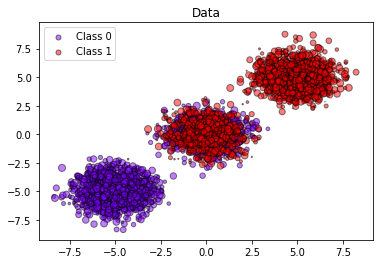

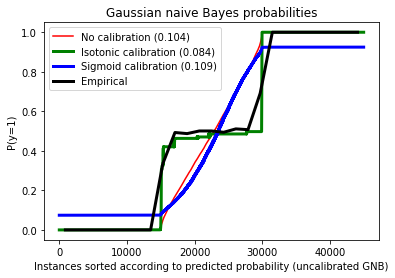

In [21]:
# Tomado de: https://scikit-learn.org/stable/auto_examples/calibration/plot_calibration.html#sphx-glr-auto-examples-calibration-plot-calibration-py
# Author: Mathieu Blondel <mathieu@mblondel.org>
#         Alexandre Gramfort <alexandre.gramfort@telecom-paristech.fr>
#         Balazs Kegl <balazs.kegl@gmail.com>
#         Jan Hendrik Metzen <jhm@informatik.uni-bremen.de>
# License: BSD Style.

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.datasets import make_blobs
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split


n_samples = 50000
n_bins = 3  # use 3 bins for calibration_curve as we have 3 clusters here

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-5, -5), (0, 0), (5, 5)]
X, y = make_blobs(n_samples=n_samples, n_features=2, cluster_std=1.0,
                  centers=centers, shuffle=False, random_state=42)

y[:n_samples // 2] = 0
y[n_samples // 2:] = 1
sample_weight = np.random.RandomState(42).rand(y.shape[0])

# split train, test for calibration
X_train, X_test, y_train, y_test, sw_train, sw_test = \
    train_test_split(X, y, sample_weight, test_size=0.9, random_state=42)

# Gaussian Naive-Bayes with no calibration
clf = GaussianNB()
clf.fit(X_train, y_train)  # GaussianNB itself does not support sample-weights
prob_pos_clf = clf.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with isotonic calibration
clf_isotonic = CalibratedClassifierCV(clf, cv=2, method='isotonic')
clf_isotonic.fit(X_train, y_train, sw_train)
prob_pos_isotonic = clf_isotonic.predict_proba(X_test)[:, 1]

# Gaussian Naive-Bayes with sigmoid calibration
clf_sigmoid = CalibratedClassifierCV(clf, cv=2, method='sigmoid')
clf_sigmoid.fit(X_train, y_train, sw_train)
prob_pos_sigmoid = clf_sigmoid.predict_proba(X_test)[:, 1]

print("Brier scores: (the smaller the better)")

clf_score = brier_score_loss(y_test, prob_pos_clf, sw_test)
print("No calibration: %1.3f" % clf_score)

clf_isotonic_score = brier_score_loss(y_test, prob_pos_isotonic, sw_test)
print("With isotonic calibration: %1.3f" % clf_isotonic_score)

clf_sigmoid_score = brier_score_loss(y_test, prob_pos_sigmoid, sw_test)
print("With sigmoid calibration: %1.3f" % clf_sigmoid_score)

# #############################################################################
# Plot the data and the predicted probabilities
plt.figure()
y_unique = np.unique(y)
colors = cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
for this_y, color in zip(y_unique, colors):
    this_X = X_train[y_train == this_y]
    this_sw = sw_train[y_train == this_y]
    plt.scatter(this_X[:, 0], this_X[:, 1], s=this_sw * 50,
                c=color[np.newaxis, :],
                alpha=0.5, edgecolor='k',
                label="Class %s" % this_y)
plt.legend(loc="best")
plt.title("Data")

plt.figure()
order = np.lexsort((prob_pos_clf, ))
plt.plot(prob_pos_clf[order], 'r', label='No calibration (%1.3f)' % clf_score)
plt.plot(prob_pos_isotonic[order], 'g', linewidth=3,
         label='Isotonic calibration (%1.3f)' % clf_isotonic_score)
plt.plot(prob_pos_sigmoid[order], 'b', linewidth=3,
         label='Sigmoid calibration (%1.3f)' % clf_sigmoid_score)
plt.plot(np.linspace(0, y_test.size, 51)[1::2],
         y_test[order].reshape(25, -1).mean(1),
         'k', linewidth=3, label=r'Empirical')
plt.ylim([-0.05, 1.05])
plt.xlabel("Instances sorted according to predicted probability "
           "(uncalibrated GNB)")
plt.ylabel("P(y=1)")
plt.legend(loc="upper left")
plt.title("Gaussian naive Bayes probabilities")

plt.show()

# 4. Curvas de validación.

Este ejemplo demuestra los problemas de subadaptación y sobreajuste y cómo podemos usar la regresión lineal con características polinómicas para aproximar funciones no lineales. La gráfica muestra la función que queremos aproximar, que es parte de la función coseno. Además, se muestran las muestras de la función real y las aproximaciones de diferentes modelos. Los modelos tienen características polinómicas de diferentes grados. Podemos ver que una función lineal (polinomio con grado 1) no es suficiente para ajustar las muestras de entrenamiento. Esto se llama underfitting. Un polinomio de grado 4 se aproxima a la función verdadera casi a la perfección. Sin embargo, para grados superiores, el modelo sobreajustará los datos de entrenamiento, es decir, aprenderá el ruido de los datos de entrenamiento. Evaluamos el sobreajuste / subadaptación cuantitativamente mediante validación cruzada. Calculamos el error cuadrático medio (MSE) en el conjunto de validación, cuanto más alto, menos probable es que el modelo se generalice correctamente a partir de los datos de entrenamiento.

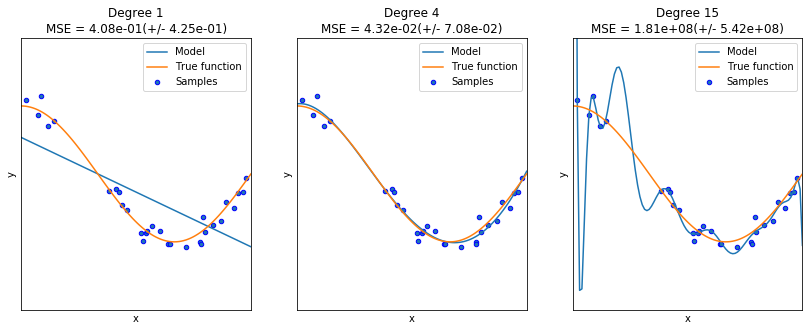

In [23]:

import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


def true_fun(X):
    return np.cos(1.5 * np.pi * X)

np.random.seed(0)

n_samples = 30
degrees = [1, 4, 15]

X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = cross_val_score(pipeline, X[:, np.newaxis], y,
                             scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, edgecolor='b', s=20, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()